In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *
from src.real_data import Metrics, Vectors 

import sklearn
from sklearn.metrics import roc_curve, auc
import pandas as pd
from supervenn import supervenn

from scipy.stats import bernoulli, spearmanr

from operator import xor

import ast

import os



In [2]:

def compute_group_stats(val, group_train, group_test, instance_err_true_train, instance_err_true_test, instance_err_pred_train, instance_err_pred_test):
    """
    Computes false positive rate (FPR), false negative rate (FNR), and regret rate for a given group value.

    Parameters:
    - val: The group value to compute statistics for.
    - group_train: Group labels for the training set.
    - group_test: Group labels for the test set.
    - instance_err_true_train: True instance errors for the training set.
    - instance_err_true_test: True instance errors for the test set.
    - instance_err_pred_train: Predicted instance errors for the training set.
    - instance_err_pred_test: Predicted instance errors for the test set.

    Returns:
    - Dictionary containing FPR, FNR, and regret rates for the specified group.
    """
    group_train = np.asarray(group_train)
    group_test = np.asarray(group_test)
    instance_err_true_train = np.asarray(instance_err_true_train)
    instance_err_true_test = np.asarray(instance_err_true_test)
    instance_err_pred_train = np.asarray(instance_err_pred_train)
    instance_err_pred_test = np.asarray(instance_err_pred_test)
    
    def calculate_rates(group, instance_err_true, instance_err_pred):
        group_indices = np.where(group == val)[0]
        instance_err_true_group = instance_err_true[group_indices]
        instance_err_pred_group = instance_err_pred[group_indices]
        
        false_positives = np.sum((instance_err_pred_group == 1) & (instance_err_true_group == 0))
        false_negatives = np.sum((instance_err_pred_group == 0) & (instance_err_true_group == 1))
        
        total_in_group = len(group_indices)
        
        fpr = false_positives / total_in_group if total_in_group > 0 else 0.0
        fnr = false_negatives / total_in_group if total_in_group > 0 else 0.0
        
        return fpr, fnr
    
    def calculate_regret_rate(group, instance_err_true, instance_err_pred):
        regret = abs(instance_err_true - instance_err_pred)
        group_indices = np.where(group == val)[0]
        regret_in_group = np.sum(regret[group_indices])
        total_in_group = len(group_indices)
        return regret_in_group / total_in_group if total_in_group > 0 else 0.0
    
    def calculate_risk_rate(group, instance_err_true):
        group_indices = np.where(group == val)[0]
        risk_in_group = np.sum(instance_err_true[group_indices])
        total_in_group = len(group_indices)
        return risk_in_group / total_in_group if total_in_group > 0 else 0.0
    
    # Calculate rates for training and test sets
    fpr_train, fnr_train = calculate_rates(group_train, instance_err_true_train, instance_err_pred_train)
    fpr_test, fnr_test = calculate_rates(group_test, instance_err_true_test, instance_err_pred_test)
    
    # Calculate regret rates
    regret_train = calculate_regret_rate(group_train, instance_err_true_train, instance_err_pred_train)
    regret_test = calculate_regret_rate(group_test, instance_err_true_test, instance_err_pred_test)
    
    risk_train = calculate_risk_rate(group_train, instance_err_true_train)
    risk_test = calculate_risk_rate(group_test, instance_err_true_test)
    
    return {
        'fpr_train': fpr_train,
        'fnr_train': fnr_train,
        'fpr_test': fpr_test,
        'fnr_test': fnr_test,
        'regret_train': regret_train,
        'regret_test': regret_test,
        'risk_train': risk_train,
        'risk_test': risk_test
    }

class MetricsCalculator:
    def __init__(self, vectors):
        """
        Initializes the MetricsCalculator with vectors and a Metrics object.

        Parameters:
        - vectors: A data structure to fetch vectors related to the metrics.
        """
        self.vectors = vectors
        self.metrics = Metrics()

    def calculate_metrics(self, draw_id):
        """
        Calculate and add various metrics to the Metrics object for a given draw_id.

        Parameters:
        - draw_id: The ID of the current draw for which metrics are calculated.
        """
        instance_err_true_train = self.vectors.get_vector("metadata", draw_id, "instance_err_true_train") #True 01 Error Train
        instance_err_true_test = self.vectors.get_vector("metadata", draw_id, "instance_err_true_test") #True 01 Error Test
        
        #self.metrics.add_metric("metadata", draw_id, "clean_acc_train", 1-np.mean(instance_err_true_train))
        #self.metrics.add_metric("metadata", draw_id, "clean_acc_test", 1-np.mean(instance_err_true_test))
        
        dataset = self.vectors.get_vector("metadata", draw_id, "dataset")
        T = self.vectors.get_vector("metadata", draw_id, "T")
        yn_train = self.vectors.get_vector("metadata", draw_id, "yn_train")
        train_preds = self.vectors.get_vector("metadata", draw_id, "train_preds")
        test_preds = self.vectors.get_vector("metadata", draw_id, "test_preds")
        train_probs = self.vectors.get_vector("metadata", draw_id, "train_probs")
        test_probs = self.vectors.get_vector("metadata", draw_id, "test_probs")
        y_train = self.vectors.get_vector("metadata", draw_id, "y_train")
        y_test = self.vectors.get_vector("metadata", draw_id, "y_test")

#         disagreement_train = self.vectors.get_vector("metadata", draw_id, "disagreement_train")
#         ambiguity_train = self.vectors.get_vector("metadata", draw_id, "ambiguity_train")
        
#         disagreement_test = self.vectors.get_vector("metadata", draw_id, "disagreement_test")
#         ambiguity_test = self.vectors.get_vector("metadata", draw_id, "ambiguity_test")
        
        
#         #Clipping to [0,1]
#         disagreement_train = np.clip(disagreement_train, 0, 1)
#         ambiguity_train = np.clip(ambiguity_train, 0, 1)
#         disagreement_test = np.clip(disagreement_test, 0, 1)
#         ambiguity_test = np.clip(ambiguity_test, 0, 1)

#         empirical_regret_train_ours = np.mean(ambiguity_train) #sum_xy regret = empirical regret estimate
#         plausible_instance_err_anticipated_train = (ambiguity_train > 0.).astype(int) #placeholder

#         empirical_regret_test_ours = np.mean(ambiguity_test) #sum_xy regret = empirical regret estimate
#         plausible_instance_err_anticipated_test = (ambiguity_test > 0.).astype(int) #placeholder
        
#         #self.metrics.add_metric("metadata", draw_id, "plausible_regret_train", np.mean(ambiguity_train))
        
        for err_method in ["01", "forward", "backward"]:
            if err_method == "01":
                pop_err_anticipated_train, instance_err_anticipated_train = instance_01loss(yn_train, train_preds)
                pop_err_anticipated_test, instance_err_anticipated_test = instance_01loss(y_test, test_preds)
                
            elif err_method == "forward":
                pop_err_anticipated_train, instance_err_anticipated_train = instance_forward_01loss(yn_train, train_probs, T)
                pop_err_anticipated_test, instance_err_anticipated_test = instance_forward_01loss(y_test, test_probs, T)
                
            elif err_method == "backward":
                _, _, pop_err_anticipated_train, instance_err_anticipated_train = natarajan_unbiased_01_loss(yn_train, train_preds, T)
                _, _, pop_err_anticipated_test, instance_err_anticipated_test = natarajan_unbiased_01_loss(y_test, test_preds, T)
                
                
            empirical_regret_train, regret_instances_train = instance_01loss(instance_err_anticipated_train, instance_err_true_train)
            #fpr_train, fp_train, fnr_train, fn_train = regret_FPR_FNR(instance_err_true_train, instance_err_anticipated_train)
            
            self.metrics.add_metric(err_method, draw_id, "regret_vector", regret_instances_train)
            
#             plausible_fpr_train, plausible_fp_train, plausible_fnr_train, plausible_fn_train = regret_FPR_FNR(regret_instances_train, plausible_instance_err_anticipated_train)
#             plausible_fpr_test, plausible_fp_test, plausible_fnr_test, plausible_fn_test = regret_FPR_FNR(regret_instances_test, plausible_instance_err_anticipated_test)
        
            #self.metrics.add_metric(err_method, draw_id, "pop_err_anticipated_train", np.mean(instance_err_anticipated_train)) #average noisy 01loss
            #self.metrics.add_metric(err_method, draw_id, "pop_err_true_train", np.mean(instance_err_true_train)) #average clean 01loss
            self.metrics.add_metric(err_method, draw_id, "risk_test", np.mean(instance_err_true_test)) #average clean 01loss
            
            #self.metrics.add_metric(err_method, draw_id, "delta_pop_err_train", abs(np.mean(instance_err_anticipated_train) - np.mean(instance_err_true_train))) #average clean 01loss
            
            self.metrics.add_metric(err_method, draw_id, "regret", empirical_regret_train)
            
            #How well ambiguity flags regretful instances
            #self.metrics.add_metric("metadata", draw_id, "coverage_regret_train", np.logical_and(plausible_instance_err_anticipated_train, regret_instances_train).sum()/regret_instances_train.sum() if regret_instances_train.sum() != 0 else 0)
        
            fp_indices_train = ((instance_err_anticipated_train == 1) & (instance_err_true_train == 0))
            fn_indices_train = ((instance_err_anticipated_train == 0) & (instance_err_true_train == 1))
            
            self.metrics.add_metric(err_method, draw_id, "fp_vector", fp_indices_train.astype(int))
            self.metrics.add_metric(err_method, draw_id, "fn_vector", fn_indices_train.astype(int))
            
            indices_regret = np.logical_or(fp_indices_train, fn_indices_train)
            
            self.metrics.add_metric(err_method, draw_id, "regret_fpr",  fp_indices_train.sum()/len(indices_regret) if len(indices_regret) != 0 else 0)
            self.metrics.add_metric(err_method, draw_id, "regret_fnr", fn_indices_train.sum()/len(indices_regret) if len(indices_regret) != 0 else 0)
            
            #FPR and FNR of plausible's ability to detect Regretful instances
#             fp_indices_train = ((plausible_instance_err_anticipated_train == 1) & (regret_instances_train == 0))
#             fn_indices_train = ((plausible_instance_err_anticipated_train == 0) & (regret_instances_train == 1))
            
            non_regret_instances_train = 1-regret_instances_train
        
            #self.metrics.add_metric("metadata", draw_id, "plausible_regret_fpr_train",  fp_indices_train.sum()/non_regret_instances_train.sum() if non_regret_instances_train.sum() != 0 else 0)
            #self.metrics.add_metric("metadata", draw_id, "plausible_regret_fnr_train", fn_indices_train.sum()/regret_instances_train.sum() if regret_instances_train.sum() != 0 else 0)
            
            regret_indices_train = np.where(regret_instances_train == 1)[0]
            #regret_indices_test = np.where(regret_instances_test == 1)[0]

            #self.metrics.add_metric(err_method, draw_id, "regret_instances_train", regret_instances_train)
            #self.metrics.add_metric(err_method, draw_id, "ambiguity_train", ambiguity_train)
            #self.metrics.add_metric(err_method, draw_id, "probs_train", train_probs)
            
            groups = ["age", "hiv"] if  (dataset == "saps" or dataset == "saps_imbalanced") else ["age", "sex"]
                    
            for group in groups:
                
                # Load the dataset splits and group labels
                _, _, _, _, group_train, group_test = load_dataset_splits(dataset, group)
                
                for val in np.unique(group_train):
                    group_stats = compute_group_stats(val, group_train, group_test, instance_err_true_train, instance_err_true_test, instance_err_anticipated_train, instance_err_anticipated_test)
                    self.metrics.add_metric(err_method, draw_id, f"fpr_{group}_{val}", group_stats["fpr_train"])
                    #self.metrics.add_metric(err_method, draw_id, f"fpr_test_{group}_{val}", group_stats["fpr_test"])
                    self.metrics.add_metric(err_method, draw_id, f"fnr_{group}_{val}", group_stats["fnr_train"])
                    #self.metrics.add_metric(err_method, draw_id, f"fnr_test_{group}_{val}", group_stats["fnr_test"])

                    self.metrics.add_metric(err_method, draw_id, f"regret_{group}_{val}", group_stats["regret_train"])
                    self.metrics.add_metric(err_method, draw_id, f"risk_{group}_{val}", group_stats["risk_test"])
            for c in [0,1]:
                
                class_stats = compute_group_stats(c, y_train, y_test, instance_err_true_train, instance_err_true_test, instance_err_anticipated_train, instance_err_anticipated_test)
                self.metrics.add_metric(err_method, draw_id, f"fpr_class_{c}", class_stats["fpr_train"])
                #self.metrics.add_metric(err_method, draw_id, f"fpr_test_{group}_{val}", group_stats["fpr_test"])
                self.metrics.add_metric(err_method, draw_id, f"fnr_class_{c}", class_stats["fnr_train"])
                #self.metrics.add_metric(err_method, draw_id, f"fnr_test_{group}_{val}", group_stats["fnr_test"])
                self.metrics.add_metric(err_method, draw_id, f"regret_class_{c}", class_stats["regret_train"])
                self.metrics.add_metric(err_method, draw_id, f"risk_class_{c}", class_stats["risk_test"])
         
                
                #class_stats = compute_group_stats(c, y_train, y_test, regret_instances_train, regret_instances_test, plausible_instance_err_anticipated_train, plausible_instance_err_anticipated_test)
                #self.metrics.add_metric(err_method, draw_id, f"plausible_regret_fpr_class_{c}_train", class_stats["fpr_train"])
                #self.metrics.add_metric(err_method, draw_id, f"plausible_regret_fnr_class_{c}_train", class_stats["fnr_train"])
                
                #self.metrics.add_metric(err_method, draw_id, f"plausible_regret_class_{c}_train", class_stats["regret_train"])
               
                
            # Visualize the binary arrays
            #self.visualize_binary_arrays(instance_err_true_train, instance_err_anticipated_train, err_method, draw_id)

    def get_metrics(self):
        """
        Returns the calculated metrics.

        Returns:
        - Metrics object containing all calculated metrics.
        """
        return self.metrics

    def visualize_binary_arrays(self, true_array, anticipated_array, err_method, draw_id):
        """
        Visualize the comparison between true and anticipated error arrays.

        Parameters:
        - true_array: Array of true errors.
        - anticipated_array: Array of anticipated errors.
        - err_method: Error method used.
        - draw_id: ID of the current draw.
        """
        df = pd.DataFrame({
            'True Error': true_array,
            'Anticipated Error': anticipated_array
        })

        plt.figure(figsize=(10, 2))
        sns.heatmap(df.T, cmap="viridis", cbar=False)
        plt.axhline(y=1, color='gray', linestyle='--') 
        plt.title(f'Comparison of True and Anticipated Errors\nMethod: {err_method}, Draw ID: {draw_id}')
        plt.xlabel('Index')
        plt.ylabel('Error Type')
        plt.show()

In [3]:
def load_vectors(dataset, model_type, noise_type, noise_level, training_loss, epsilon=0.1, misspecify="correct", fixed_class = None, fixed_noise = None):
    """
    Load the vectors data from the specified path.

    Parameters:
    - parent_dir (str): The parent directory path.
    - dataset (str): The dataset name.
    - model_type (str): The model type.
    - noise_type (str): The noise type.
    - misspecify (str): The misspecify parameter.
    - noise_level (str): The noise level.
    - epsilon (str): The epsilon value.

    Returns:
    - vectors: The loaded vectors data.
    """
    parent_dir = "/scratch/hdd001/home/snagaraj/"
    files_path = os.path.join(parent_dir, "results", "regret", dataset, model_type, noise_type, misspecify)
    
    if noise_type == "class_independent":
        path = os.path.join(files_path, f"{training_loss}_{noise_level}_{epsilon}_vectors.pkl")
    elif noise_type == "class_conditional":
        path = os.path.join(files_path, f"{training_loss}_{noise_level}_{fixed_class}_{fixed_noise}_{epsilon}_vectors.pkl")

    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file at path {path} does not exist.")
    
    # Load the vectors data from the file
    with open(path, 'rb') as file:
        vectors = pkl.load(file)
    
    return vectors


In [59]:
dataset = "cshock_eicu"
noise_type = "class_independent"
model_type = "LR"
n_models = 2
n_draws = 1
max_iter = 10000

T = np.array([[0.6, 0.4],
              [0.4, 0.6]])

all_metrics_test = []

for training_loss in ["None"]:
    vectors = run_experiment(dataset, noise_type, model_type, n_models=n_models, max_iter=max_iter, training_loss=training_loss, T=T, n_draws = n_draws)
    
    metrics_calculator = MetricsCalculator(vectors)
    
    for draw_id in range(n_draws):
        metrics_calculator.calculate_metrics(draw_id)
        
    metrics = metrics_calculator.get_metrics()
    
    #

    for method in ["metadata", "01", "forward", "backward"]:
        for draw_id in range(n_draws):
             #Get all metric names dynamically
            all_metric_names = metrics.get_all_metrics(method, draw_id)
            for metric_name in all_metric_names:
                value = metrics.get_metric(method, draw_id, metric_name)
                if value is not None:
                    all_metrics_test.append({
                        "training_loss": training_loss,
                        "err_method": method,
                        "draw_id": draw_id,
                        "metric_name": metric_name,
                        "value": value
                    })



In [60]:
# Create a DataFrame from the collected metrics
metrics_df_test = pd.DataFrame(all_metrics_test)
#metrics_df[metrics_df["metric_name"]== "actual_regret_train"]
print(sorted(metrics_df_test.metric_name.unique()))

['fn_vector', 'fnr_age_0', 'fnr_age_1', 'fnr_class_0', 'fnr_class_1', 'fnr_sex_0', 'fnr_sex_1', 'fp_vector', 'fpr_age_0', 'fpr_age_1', 'fpr_class_0', 'fpr_class_1', 'fpr_sex_0', 'fpr_sex_1', 'regret', 'regret_age_0', 'regret_age_1', 'regret_class_0', 'regret_class_1', 'regret_fnr', 'regret_fpr', 'regret_sex_0', 'regret_sex_1', 'regret_vector', 'risk_age_0', 'risk_age_1', 'risk_class_0', 'risk_class_1', 'risk_sex_0', 'risk_sex_1', 'risk_test']


In [61]:
metrics_df_test

,training_loss,err_method,draw_id,metric_name,value
0,None,01,0,regret_vector,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, ..."
1,None,01,0,risk_test,0.367052
2,None,01,0,regret,0.404124
3,None,01,0,fp_vector,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, ..."
4,None,01,0,fn_vector,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...
88,None,backward,0,risk_class_0,0.414566
89,None,backward,0,fpr_class_1,0.254128
90,None,backward,0,fnr_class_1,0.136396
91,None,backward,0,regret_class_1,0.390524


# Load Data

In [92]:
all_metrics = []

for dataset in tqdm(["cshock_eicu_imbalanced", "cshock_mimic_imbalanced", "cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer", "saps_imbalanced", "support_imbalanced", "lungcancer_imbalanced"]):
    for model_type in ["LR", "NN"]:
        for noise_type in ["class_independent", "class_conditional"]:
            for noise_level in [0.0, 0.01, 0.05, 0.2, 0.4]:
                for training_loss in ["None", "backward", "forward"]:
                    
                    if training_loss == "None":
                        method_lis = ["metadata", "01"]
                    else:
                        method_lis =  ["metadata"] +[training_loss]
                        
                        
                    try:
                        vectors = load_vectors(dataset, model_type, noise_type, noise_level=noise_level, training_loss = training_loss, fixed_noise=fixed_noise, fixed_class= fixed_class)
                    except Exception as e:
                        continue
                        #print(e)

                    metrics_calculator = MetricsCalculator(vectors)
    
                    n_draws = len(metrics_calculator.vectors.vectors['metadata'])
                    metrics = metrics_calculator.get_metrics()

                    for draw_id in range(n_draws):
                        metrics_calculator.calculate_metrics(draw_id)

                    
                        groups = ["age", "hiv"] if  (dataset == "saps" or dataset == "saps_imbalanced") else ["age", "sex"]
                    
                        for method in method_lis:
                            
                             #Get all metric names dynamically
                            all_metric_names = sorted(metrics.get_all_metrics(method, draw_id))
                            for metric_name in all_metric_names:

                                value = metrics.get_metric(method, draw_id, metric_name)

                                #if "vector"  in metric_name:
                                #print(value)
                                all_metrics.append({
                                    "dataset": dataset,
                                    "model_type": model_type,
                                    "noise_type": noise_type,
                                    "noise_level": noise_level,
                                    "training_loss": training_loss,
                                    "err_method": method, #ignore err_method column for now
                                    "draw_id": draw_id,
                                    "metric_name": metric_name,
                                    "value": value*100
                                })
#                                 else "vector" not in metric_name:
#                                     all_metrics.append({
#                                         "dataset": dataset,
#                                         "model_type": model_type,
#                                         "noise_type": noise_type,
#                                         "noise_level": noise_level,
#                                         "training_loss": training_loss,
#                                         "err_method": method, #ignore err_method column for now
#                                         "draw_id": draw_id,
#                                         "metric_name": metric_name,
#                                         "value":value*100
#                                     })



  0%|          | 0/10 [00:00<?, ?it/s]

In [93]:
# metrics_df = pd.DataFrame(all_metrics)
# metrics_df.to_csv('all_results.csv', index=False)
# metrics_df

,dataset,model_type,noise_type,noise_level,training_loss,err_method,draw_id,metric_name,value
0,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fn_vector,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fnr_age_0,0.0
2,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fnr_age_1,0.0
3,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fnr_class_0,0.0
4,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fnr_class_1,0.0
...,...,...,...,...,...,...,...,...,...
1907995,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,99,risk_class_0,0.0
1907996,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,99,risk_class_1,100.0
1907997,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,99,risk_sex_0,7.781397
1907998,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,99,risk_sex_1,6.470147


In [94]:
metrics_df = pd.read_csv('all_results.csv')
metrics_df['training_loss'] = metrics_df['training_loss'].fillna("None")
metrics_df

,dataset,model_type,noise_type,noise_level,training_loss,err_method,draw_id,metric_name,value
0,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fn_vector,[0 0 0 ... 0 0 0]
1,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fnr_age_0,0.0
2,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fnr_age_1,0.0
3,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fnr_class_0,0.0
4,cshock_eicu_imbalanced,LR,class_independent,0.0,None,01,0,fnr_class_1,0.0
...,...,...,...,...,...,...,...,...,...
1907995,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,99,risk_class_0,0.0
1907996,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,99,risk_class_1,100.0
1907997,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,99,risk_sex_0,7.781397032211365
1907998,lungcancer_imbalanced,NN,class_conditional,0.4,forward,forward,99,risk_sex_1,6.470147389457906


In [97]:
def convert_to_float(value):
    try:
        # Evaluate the string to a Python object
        evaluated_value = ast.literal_eval(value)
        # If the evaluated value is a list or array, return the first element as float
        if isinstance(evaluated_value, (list, np.ndarray)):
            return float(evaluated_value[0])
        # Otherwise, return the value as float
        return float(evaluated_value)
    except (ValueError, SyntaxError):
        # Handle cases where conversion to float fails
        return np.nan
    
def create_boxplot(df, metric_names, ncols=4):
    # Convert the 'value' column to float
    df['value'] = df['value'].apply(convert_to_float)
    
    #df = df[df['err_method'] == "01"]
    # Original plots conditioned on training loss
    nrows = (len(metric_names) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), sharey=False)
    axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

    for i, metric_name in enumerate(metric_names):
        sns.boxplot(ax=axs[i], x='noise_level', y='value', hue='training_loss', data=df[df['metric_name'] == metric_name], dodge=True, showfliers=False)
        sns.stripplot(ax=axs[i], x='noise_level', y='value', hue='training_loss', data=df[df['metric_name'] == metric_name], 
                      dodge=True, marker='o', s=3, alpha=1, palette='dark:black', legend=False)

        axs[i].set_title(f'{metric_name}')

        # Remove the duplicate legends from the stripplot
        if i == 0:
            handles, labels = axs[i].get_legend_handles_labels()
            fig.legend(handles, labels, title='Training Loss', bbox_to_anchor=(1.05, 0.5), loc='center')
        #axs[i].legend_.remove()

    # Remove any empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title and legend
    plt.show()

    # Subgroup comparisons for err_method == "01"
    df_subset = df[df['err_method'] == "01"]

    # Collect unique base metrics and their subgroups
    subgroup_metrics = {}
    for metric_name in df_subset['metric_name'].unique():
        parts = metric_name.rsplit('_', 2)
        if len(parts) == 3:
            base_metric = '_'.join(parts[:-2])
            subgroup = f"{parts[-2]}_{parts[-1]}"
            subgroup_type = parts[-2]
            if subgroup_type not in subgroup_metrics:
                subgroup_metrics[subgroup_type] = {}
            if base_metric not in subgroup_metrics[subgroup_type]:
                subgroup_metrics[subgroup_type][base_metric] = []
            subgroup_metrics[subgroup_type][base_metric].append(subgroup)

    # Plot each subgroup type with its base metrics in one row
    for subgroup_type, base_metrics_dict in subgroup_metrics.items():
        ncols = len(base_metrics_dict)
        fig, axs = plt.subplots(1, ncols, figsize=(3 * ncols, 3), sharey=False)
        if ncols == 1:
            axs = [axs]  # Ensure axs is iterable

        for j, (base_metric, subgroups) in enumerate(base_metrics_dict.items()):
            ax = axs[j]

            merged_data = pd.concat([df_subset[df_subset['metric_name'] == f"{base_metric}_{subgroup}"] for subgroup in subgroups])
            merged_data['subgroup'] = merged_data['metric_name'].apply(lambda x: '_'.join(x.split('_')[-2:]))
            
            sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
            sns.stripplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, 
                          dodge=True, marker='o', s=3, alpha=1, palette='dark:black', legend=False)

            ax.set_title(f'{base_metric} {subgroup_type} Comparison')

        # Add a single legend for all subplots in this row
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, title='Subgroup', bbox_to_anchor=(1.05, 0.5), loc='center')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

cshock_eicu


/tmp/ipykernel_10666/2051400783.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].apply(convert_to_float)


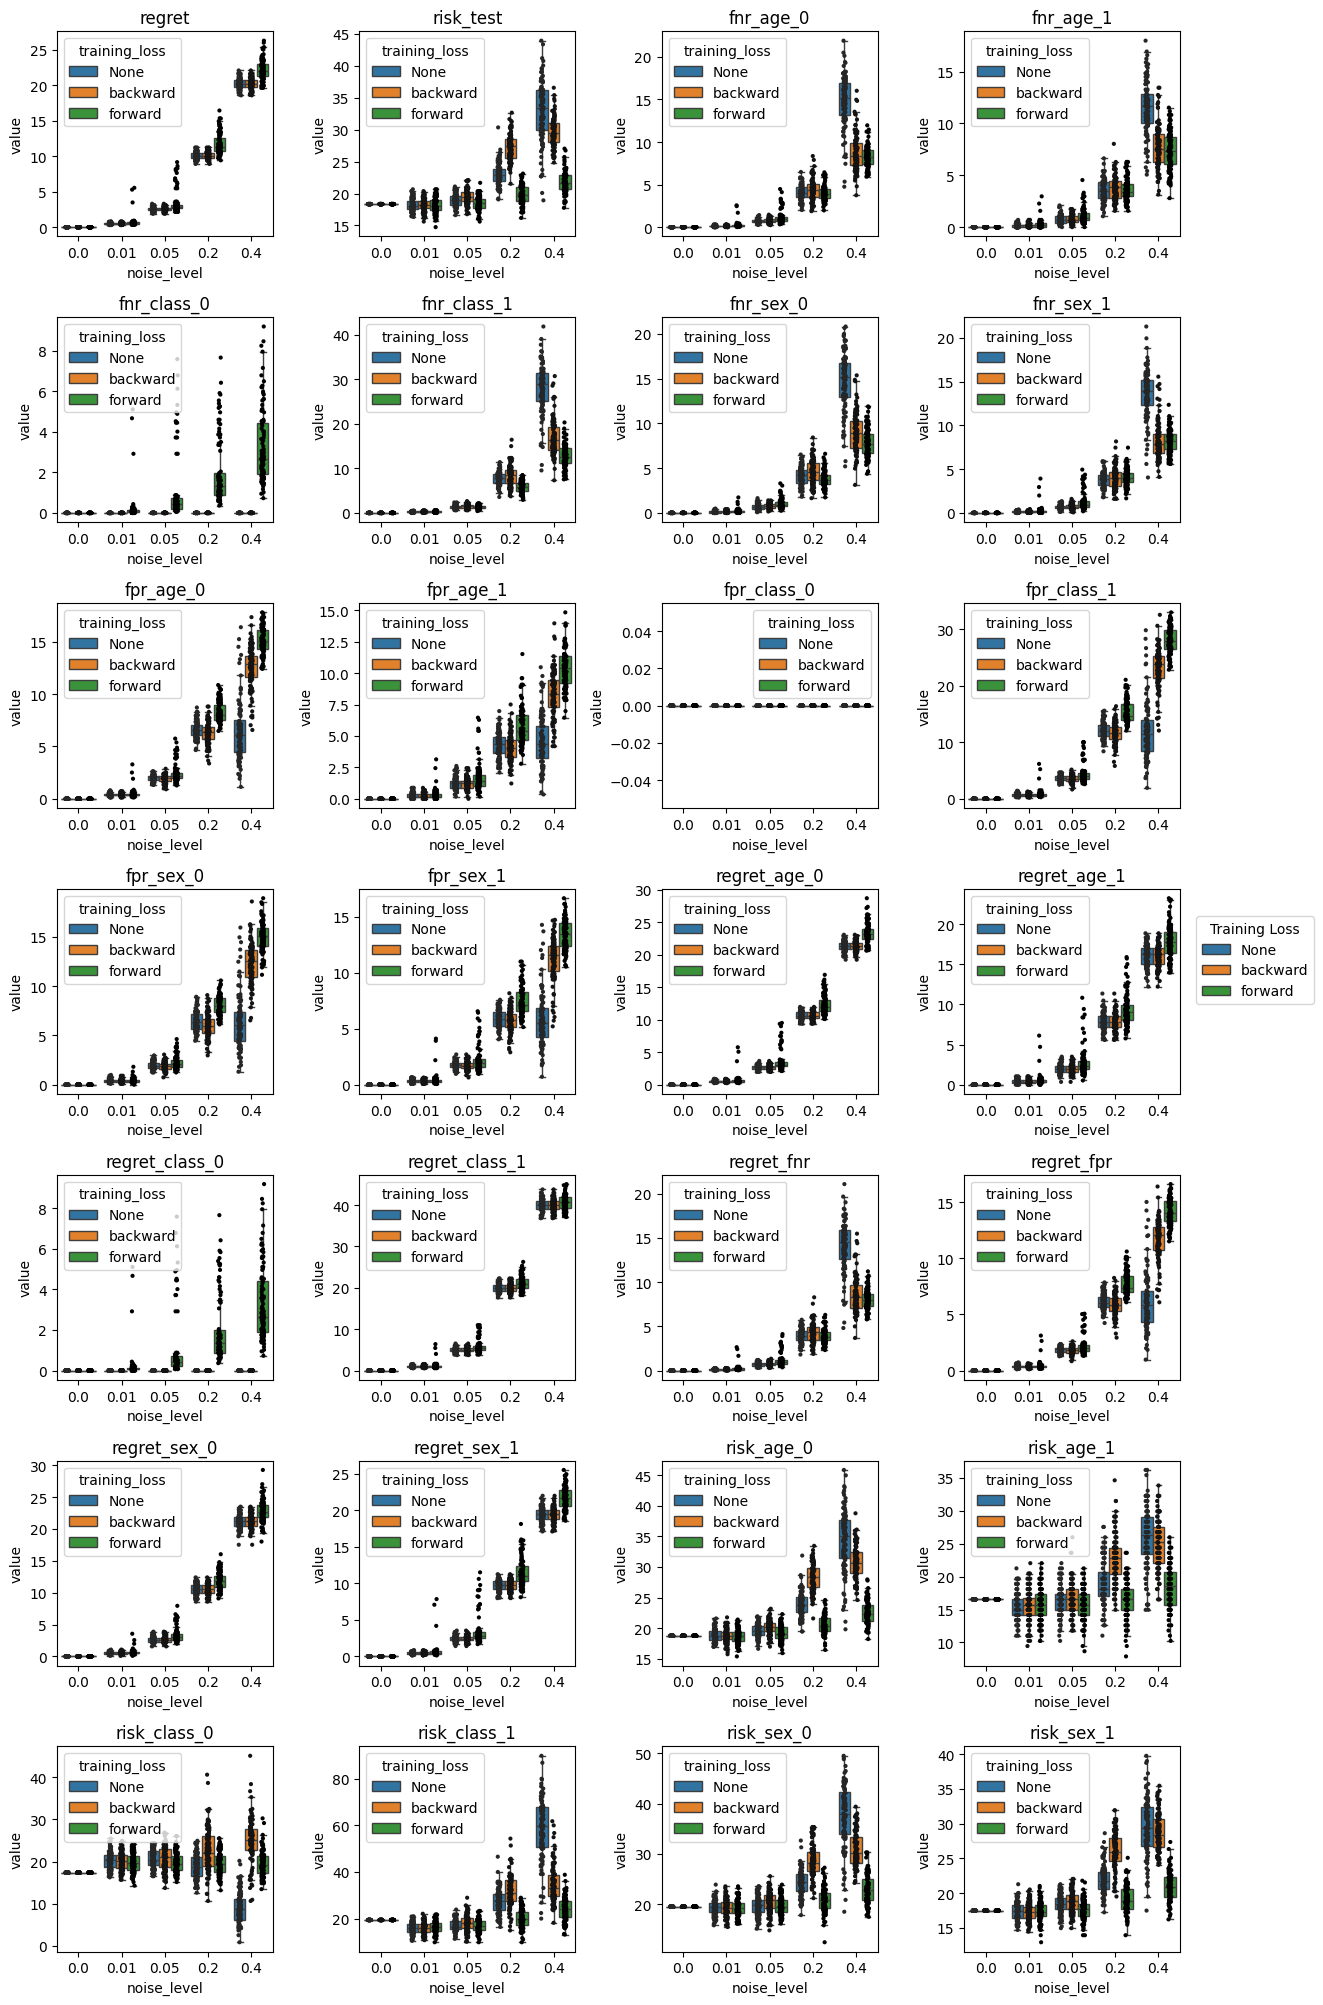

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

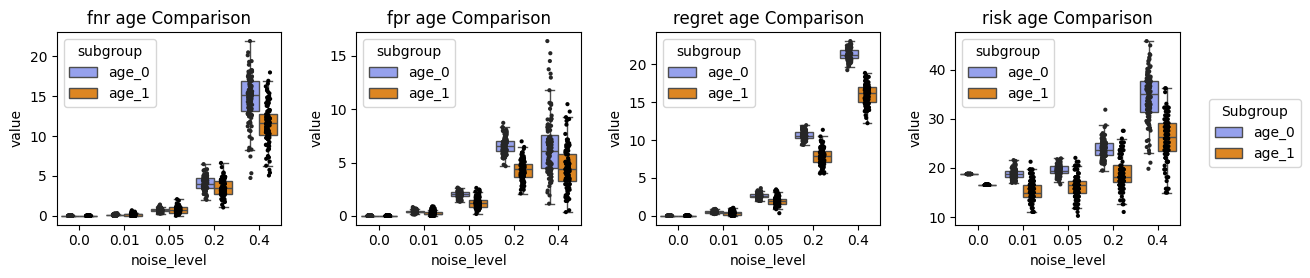

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

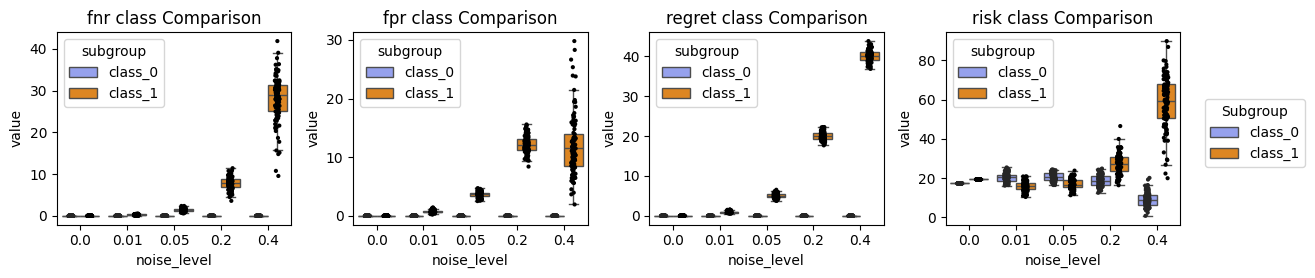

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

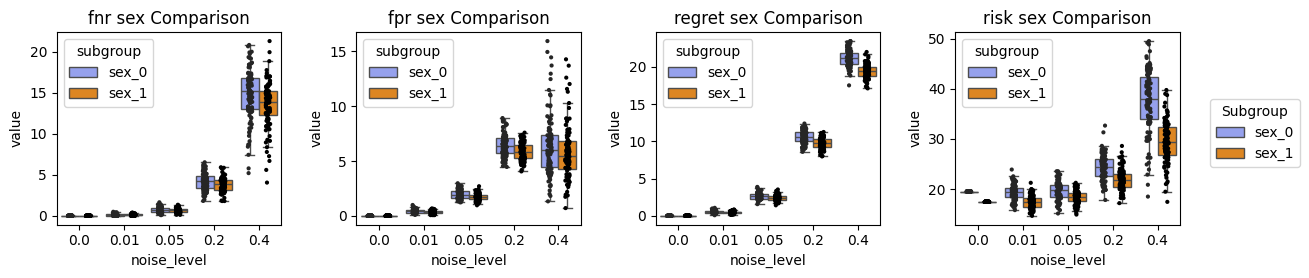

cshock_eicu_imbalanced


/tmp/ipykernel_10666/2051400783.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].apply(convert_to_float)


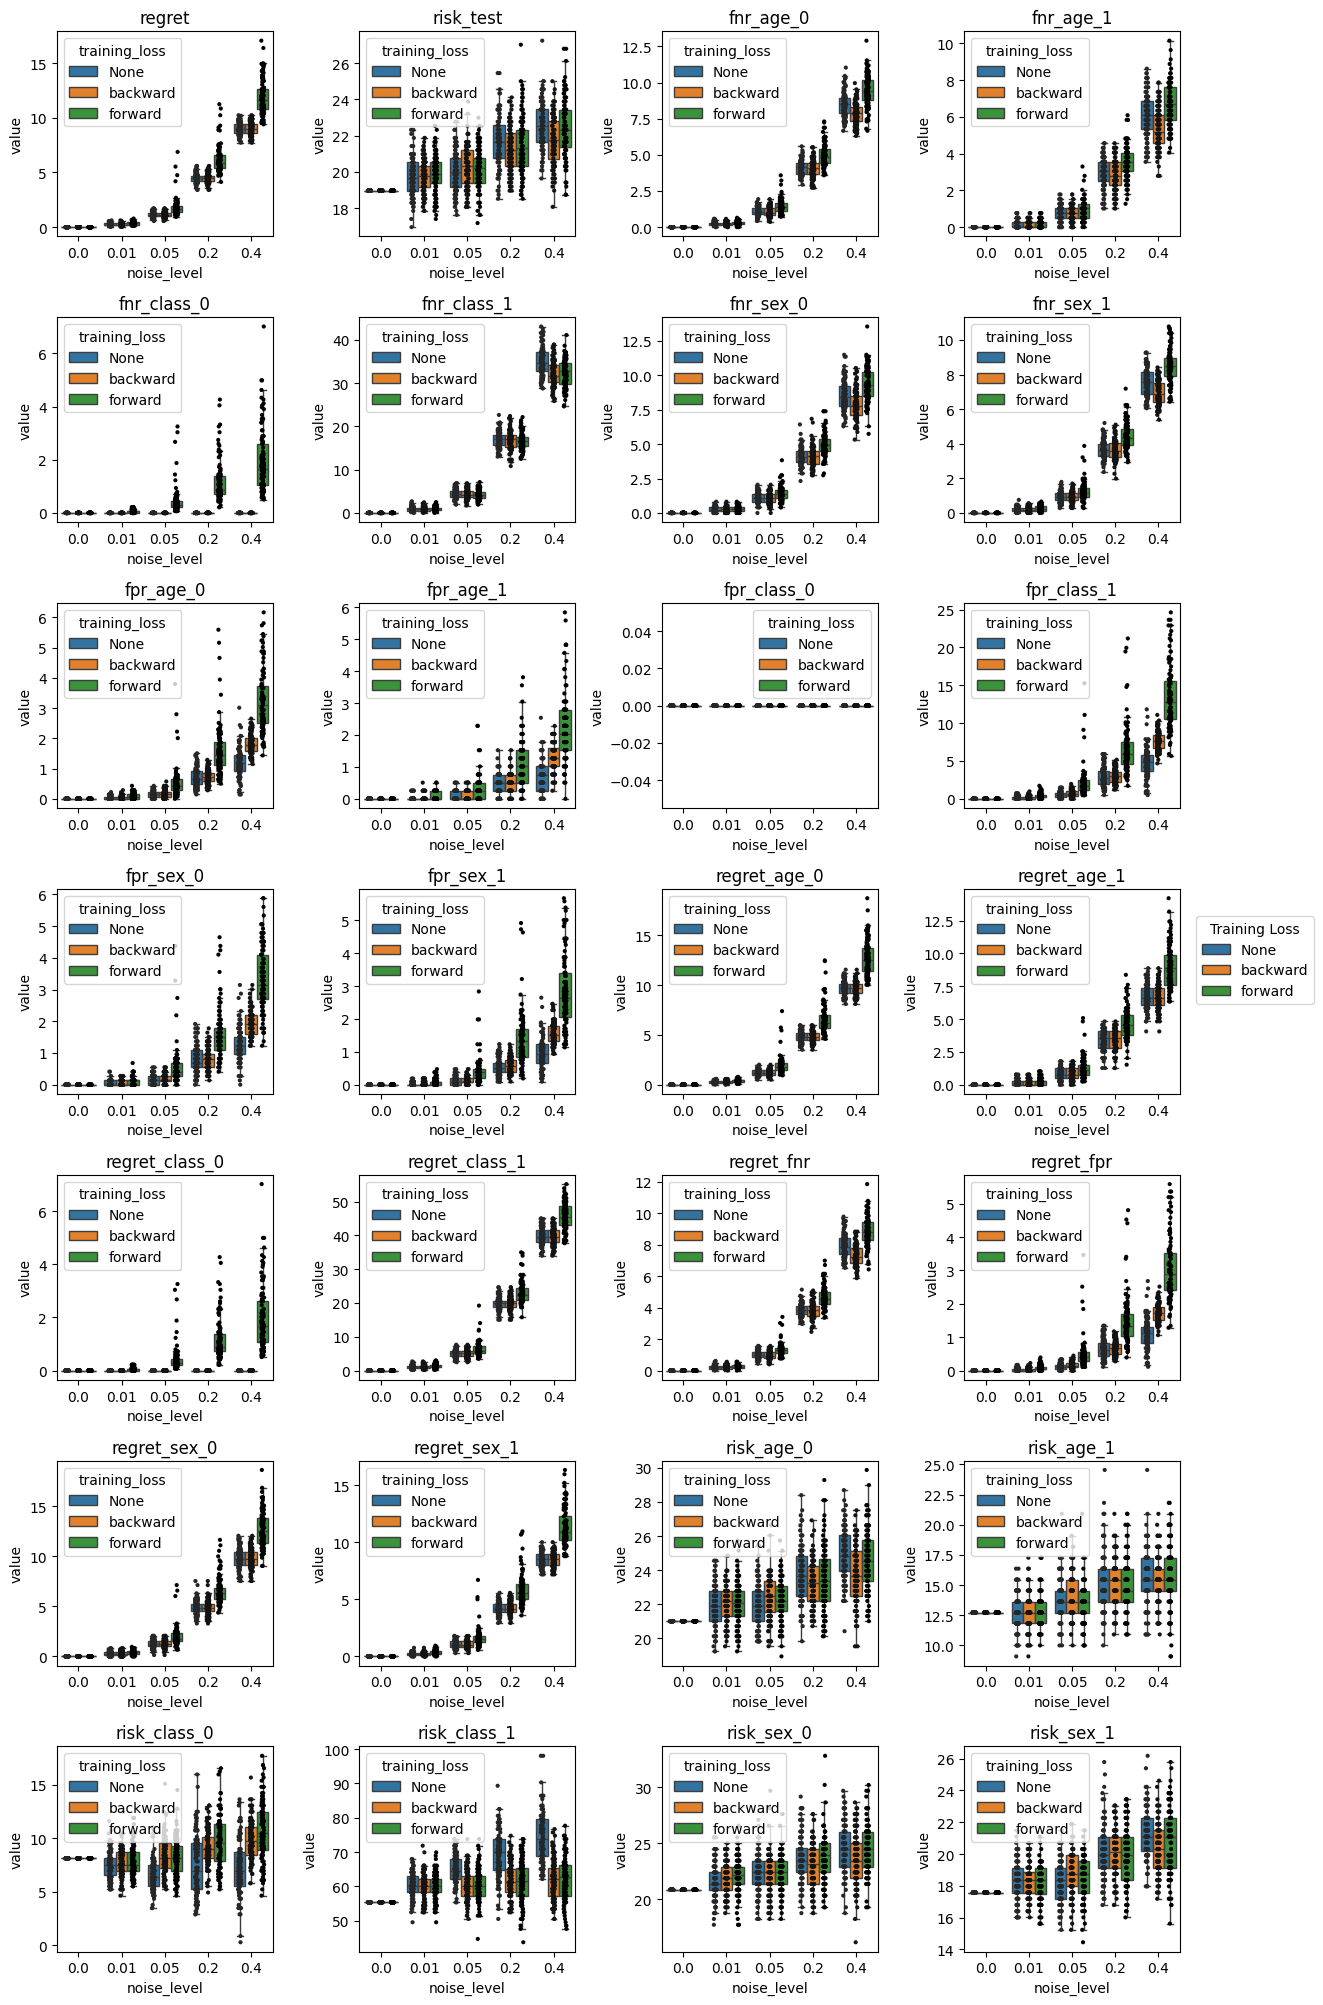

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

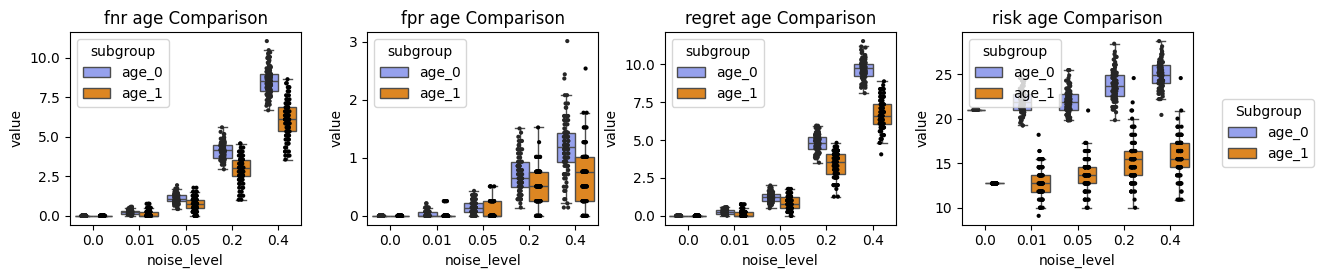

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

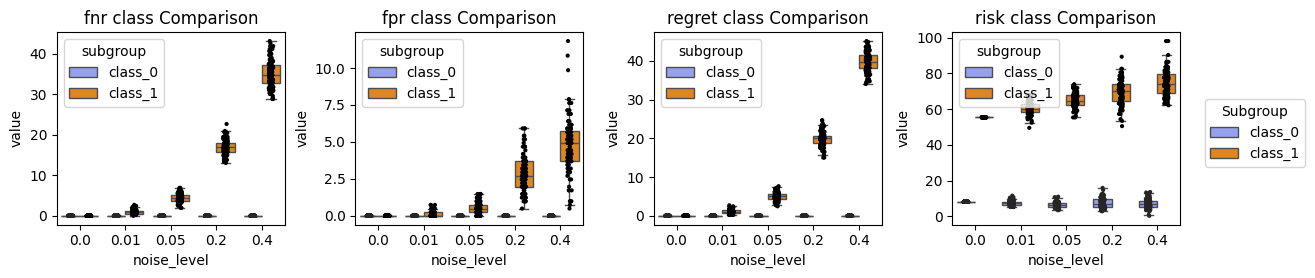

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

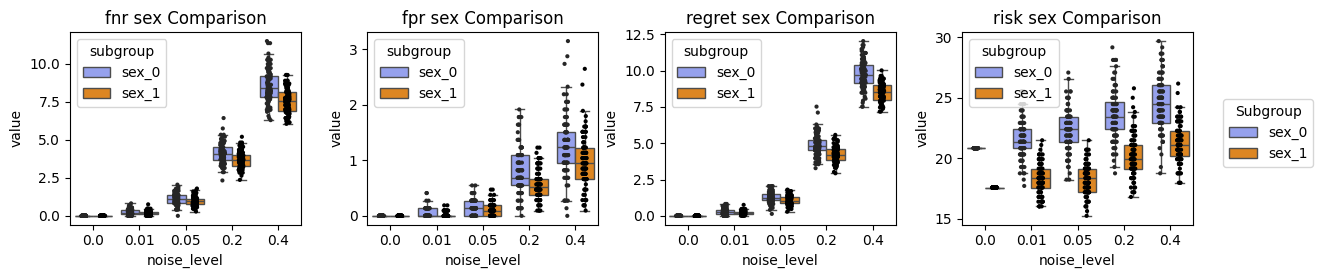

cshock_mimic


/tmp/ipykernel_10666/2051400783.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].apply(convert_to_float)


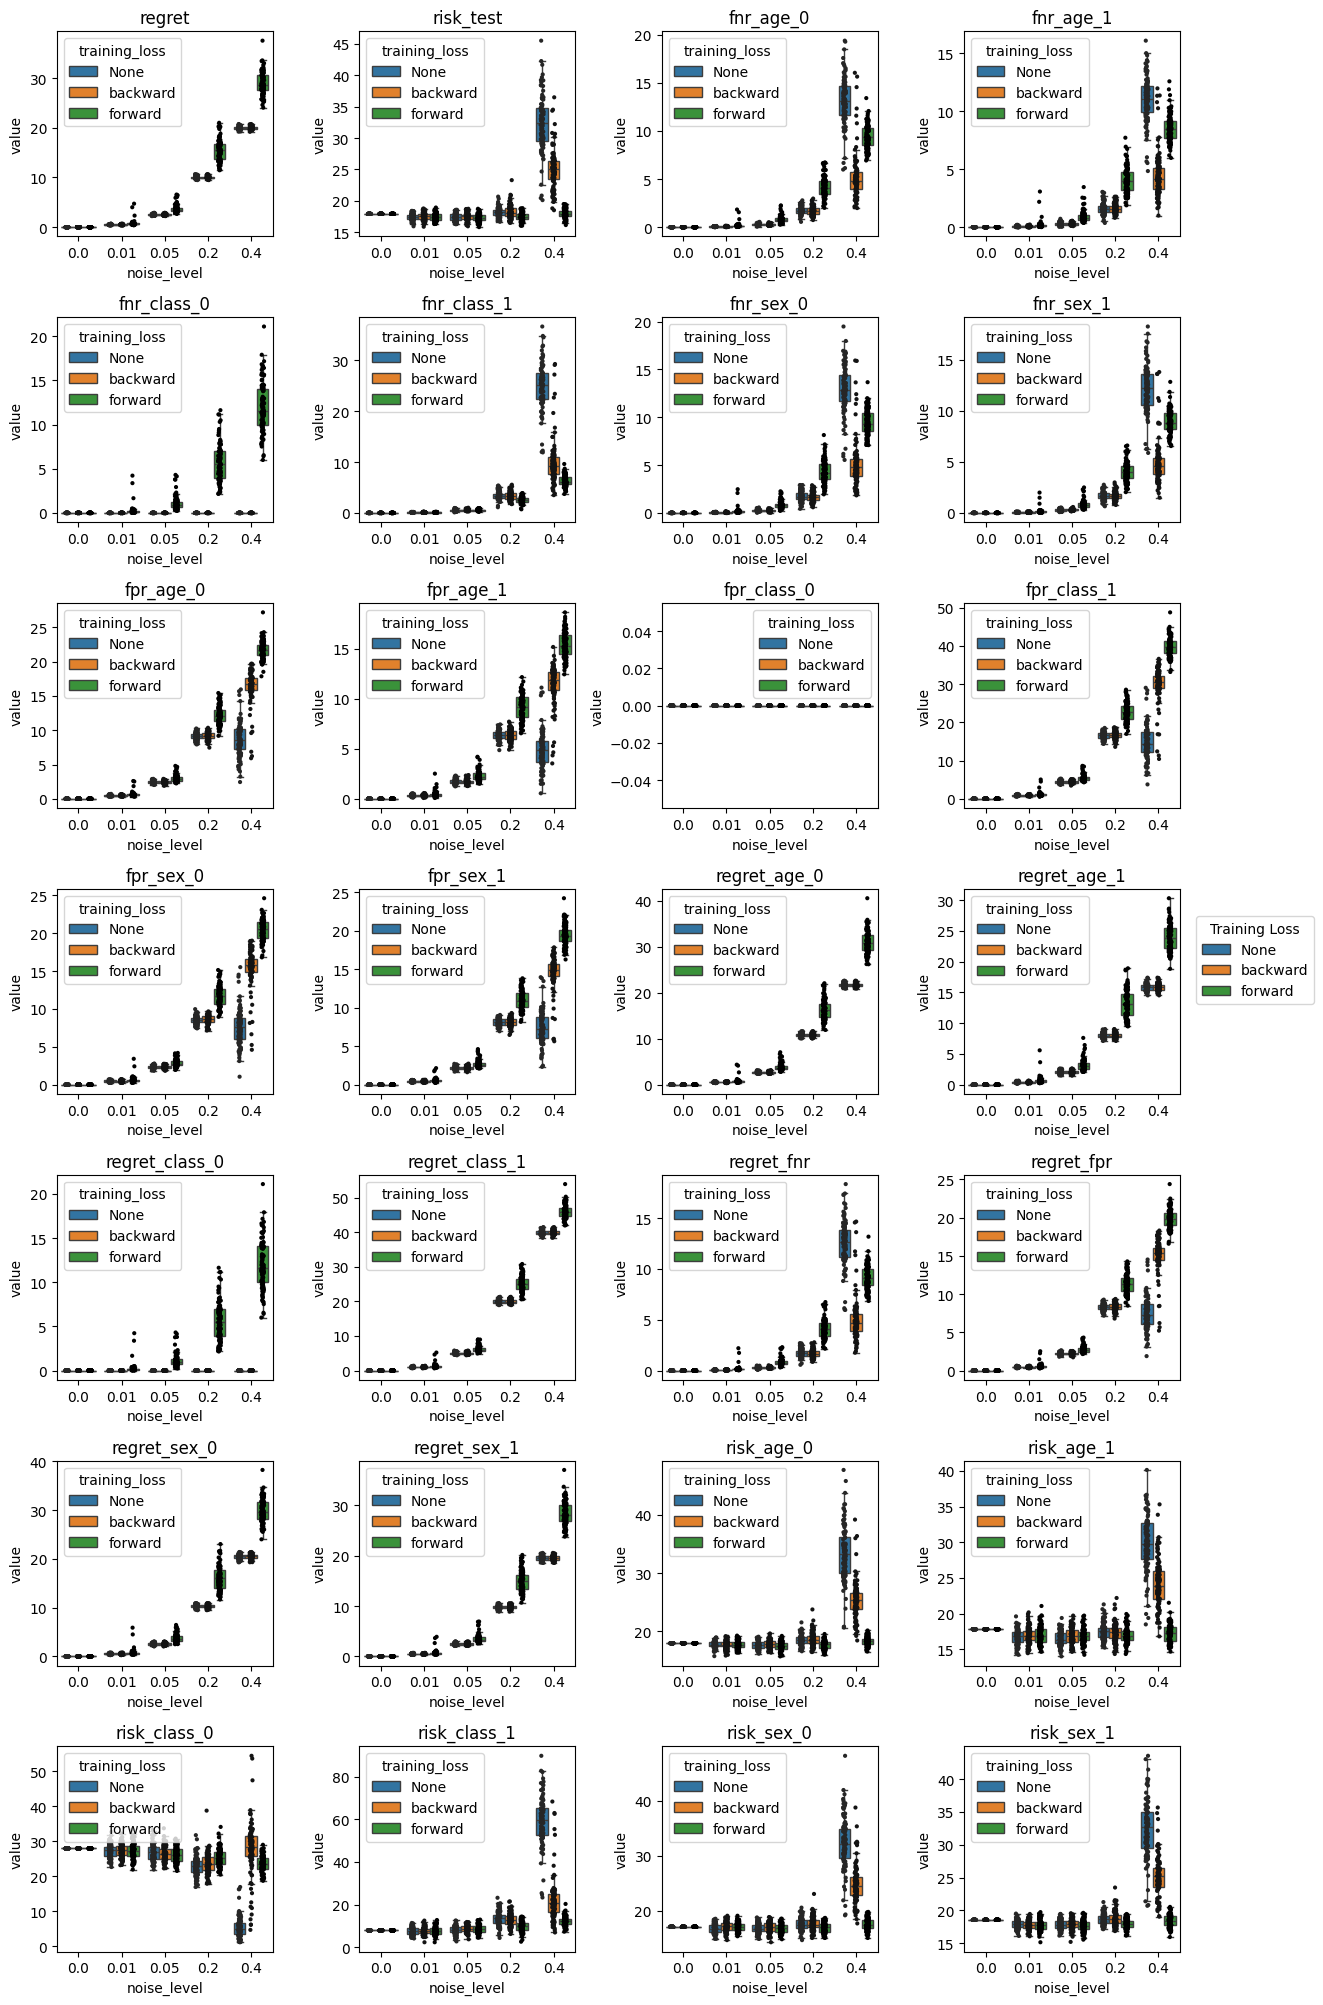

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

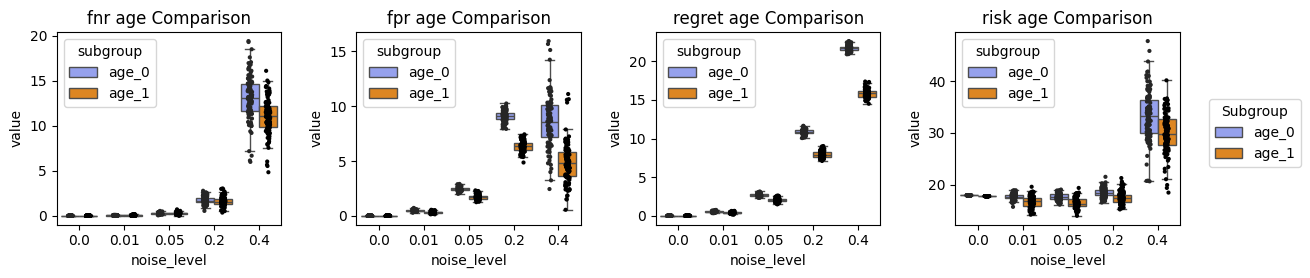

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

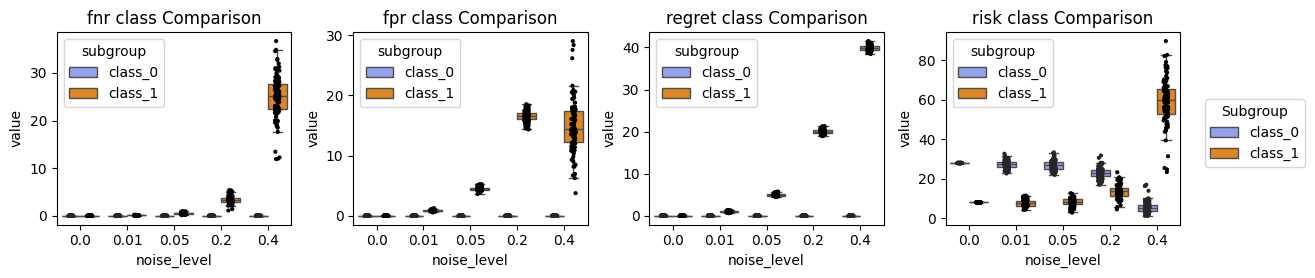

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

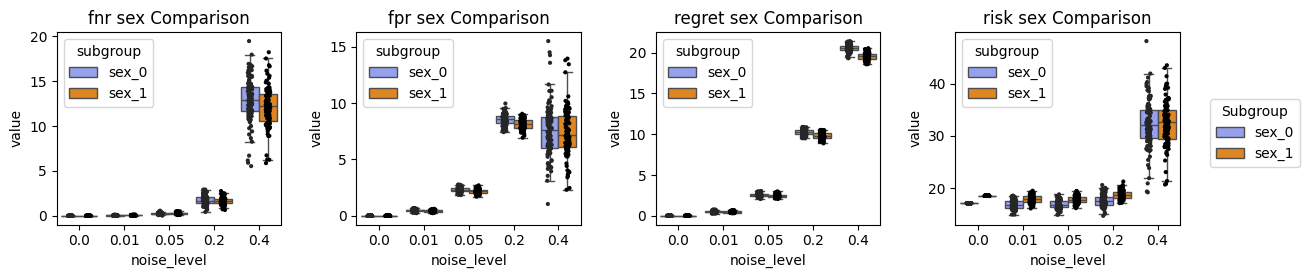

cshock_mimic_imbalanced


/tmp/ipykernel_10666/2051400783.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].apply(convert_to_float)


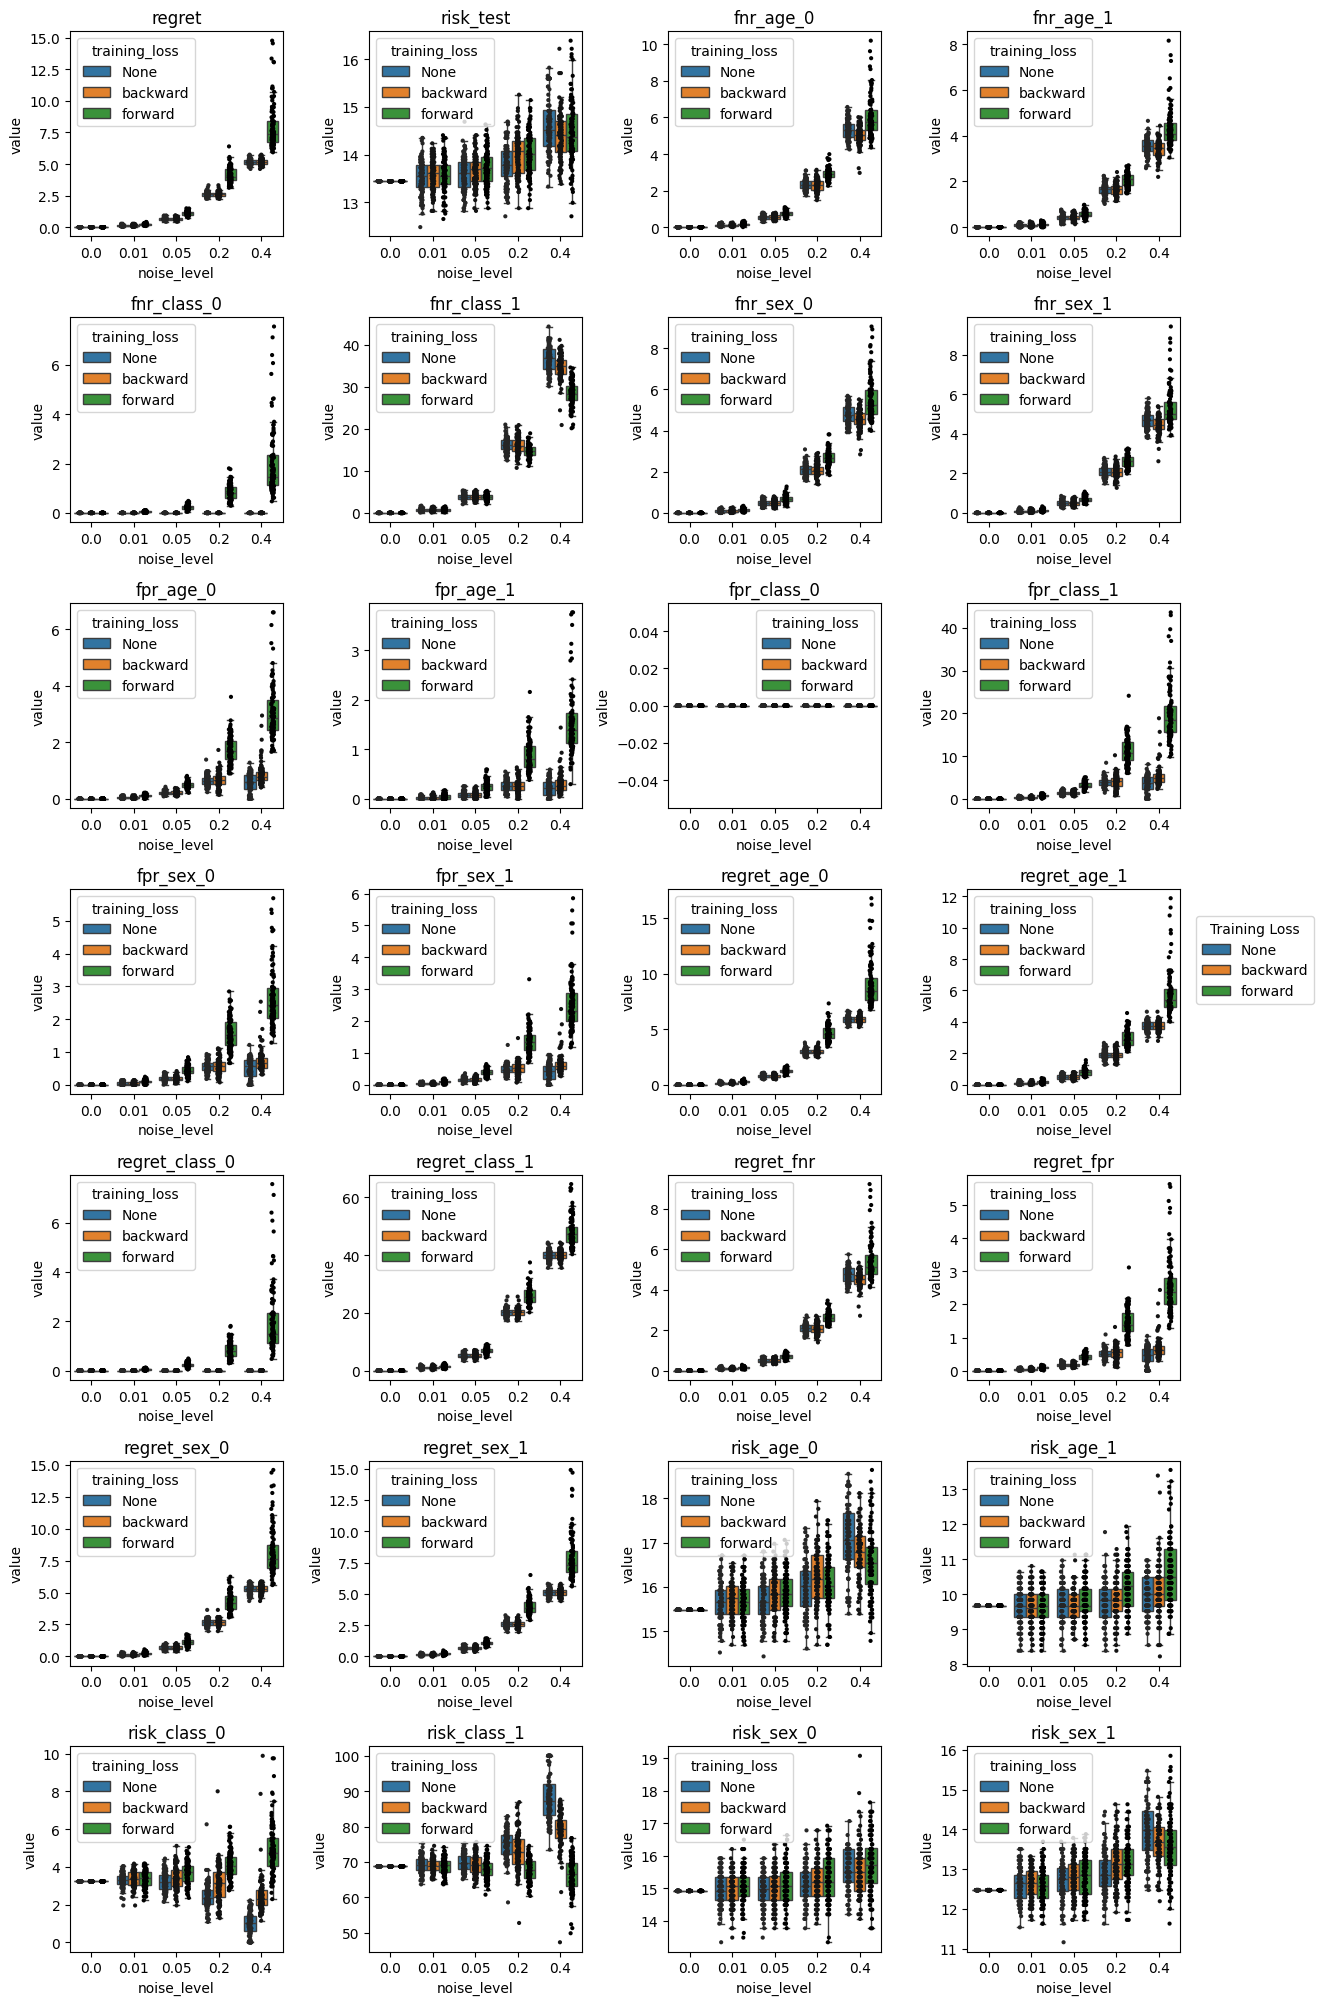

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

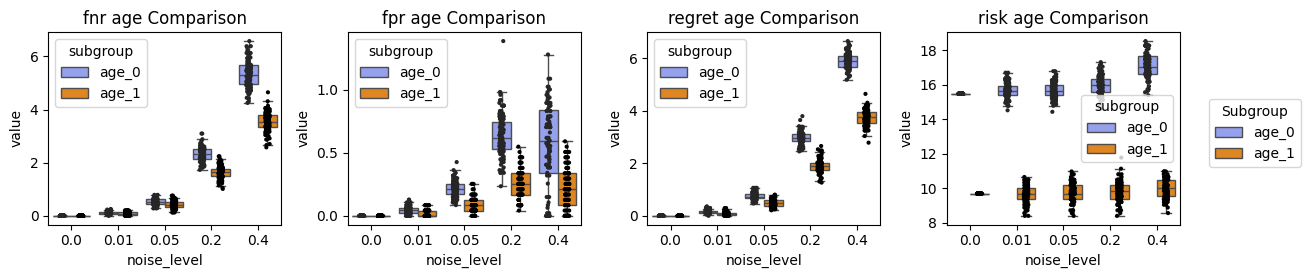

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

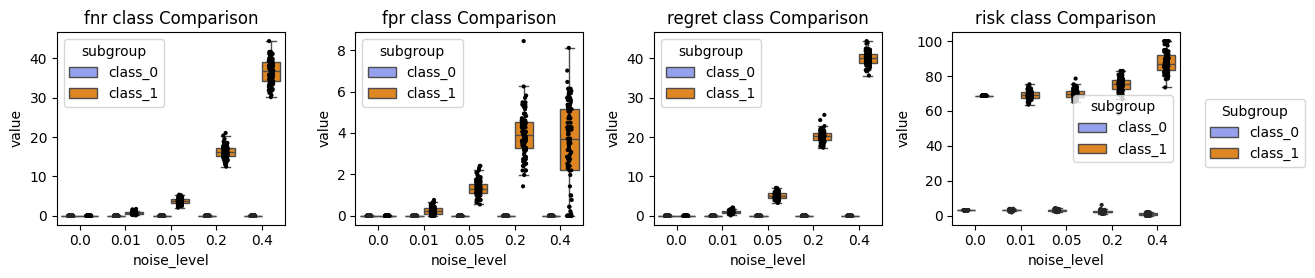

/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(ax=ax, x='noise_level', y='value', hue='subgroup', data=merged_data, dodge=True, showfliers=False, palette= ["#8896FB", "#fc8803", "#4ed476"])
/tmp/ipykernel_10666/2051400783.py:74: UserWarning: The palette list has more values (3) than needed (2), which may not be intende

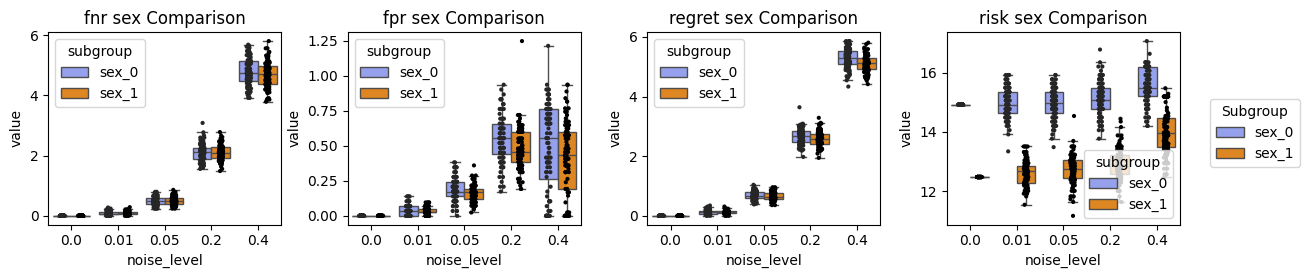

In [121]:
model_type = "NN"
noise_type = "class_conditional"

for dataset in ["cshock_eicu",
                "cshock_eicu_imbalanced",
                "cshock_mimic",
                "cshock_mimic_imbalanced",
                "support",
                "support_imbalanced",
                "saps",
                "saps_imbalanced",
                "lungcancer",
                "lungcancer_imbalanced"
                ][:4]:

    sub_df = metrics_df[(metrics_df["model_type"]==model_type) & 
                        (metrics_df["noise_type"]==noise_type) & 
                        (metrics_df["dataset"]==dataset)]
    
    
    
    metric_names = sorted(sub_df.metric_name.unique())
    # Remove any metric names containing '_vector'
    metric_names = [name for name in metric_names if '_vector' not in name]
    
    # Define the custom sorting order
    priority_metrics = ["regret", "risk_test"]

    # Sort the metric names while keeping "regret" and "risk" at the first two indices
    metric_names = priority_metrics + sorted([name for name in metric_names if name not in priority_metrics])
    print(dataset)
    create_boxplot(sub_df, metric_names)


# Regret instances across draw

In [99]:

# Initialize an empty list to store the results


# Loop over each dataset
for dataset in [
    "cshock_eicu", "cshock_eicu_imbalanced", "cshock_mimic", "cshock_mimic_imbalanced", 
    "support", "support_imbalanced", "saps", "saps_imbalanced", "lungcancer", "lungcancer_imbalanced"][:1]:
    sub_df = metrics_df[
        (metrics_df["model_type"] == model_type) & 
        (metrics_df["noise_type"] == noise_type) & 
        (metrics_df["dataset"] == dataset) & 
        (metrics_df["metric_name"] == "regret_vector")
    ]
    
    # Loop over each noise level
    results = []
    for noise_level in sub_df["noise_level"].unique():
        noise_df = sub_df[sub_df["noise_level"] == noise_level]
        
        # Extract the 'value' column and calculate the frequency of 1s
        individual_freq = np.mean([np.array(row) for row in noise_df["value"]], axis=0)
        
        # Create a DataFrame for the current noise level
        noise_df = pd.DataFrame({
            'individual_id': range(len(individual_freq)),
            'regret_rate': individual_freq,
            'noise_level': noise_level
        })
        
        # Append to the results list
        results.append(noise_df)

    # Concatenate all results into a single DataFrame
    final_df = pd.concat(results)

    # Plot the KDE plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=final_df, x='regret_rate', hue='noise_level', common_norm=False)
    plt.title('KDE Plot of Regret Rate by Noise Level')
    plt.xlabel('Regret Rate')
    plt.ylabel('Density')
    #plt.legend(title='Noise Level')
    plt.show()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U17'), dtype('<U17')) -> None

In [114]:
import pandas as pd
import numpy as np

# Function to convert the string representation to a numpy array
def str_to_array(s):
    # Remove the brackets and split by spaces
    s = s.strip('[]')
    # Convert the string elements to integers and form a numpy array
    return np.array(list(map(int, s.split())), dtype=int)

# Example dataframe
# noise_df = pd.DataFrame({'value': ["[0 0 0 ... 0 0 0]", "[1 2 3 ... 4 5 6]"]})  # Example format

# Apply the function to the 'value' column
noise_df['value'] = noise_df['value'].apply(str_to_array)

# Verify the conversion
print(noise_df['value'].head())

ValueError: invalid literal for int() with base 10: '...'